# Dropout

Dropout [1] is a technique for **regularizing neural networks** by randomly setting some features to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

![](Dropout.png)

## 1. Basic settings

In [1]:
import time
import numpy as np
from CS231n.classifiers.fc_net import *
from CS231n.data_utils import get_CIFAR10_data
from CS231n.solver import Solver
from CS231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# Optional setting
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## 2. Data loading and Preprocessing 

In [5]:
# Load the CIFAR10 data.
DIR_data = 'D:/CS231N_CNN/DataSet/cifar-10-batches-py/'

# the mean image has been sub-tracted
data = get_CIFAR10_data(DIR_data, num_training=49000, num_validation=1000)
# data is a dictionary:
# data = {
#        'X_train': X_train, 'y_train': y_train,
#        'X_val': X_val, 'y_val': y_val,
#        'X_test': X_test, 'y_test': y_test,
#    }

for k, v in data.items():
    print("The shape of %s is " %k,v.shape)

The shape of X_train is  (49000, 3, 32, 32)
The shape of y_train is  (49000,)
The shape of X_val is  (1000, 3, 32, 32)
The shape of y_val is  (1000,)
The shape of X_test is  (1000, 3, 32, 32)
The shape of y_test is  (1000,)


## 3.1. Dropout: Forward Pass

Vanilla dropout in an example 3-layer Neural Network would be implemented as follows:
```python
""" Vanilla Dropout: Not recommended implementation (see notes below) """

p = 0.5 # probability of keeping a unit active. higher = less dropout

def train_step(X):
  """ X contains the data """
  
  # forward pass for example 3-layer neural network
  H1 = np.maximum(0, np.dot(W1, X) + b1)
  U1 = np.random.rand(*H1.shape) < p # first dropout mask
  H1 *= U1 # drop!
  H2 = np.maximum(0, np.dot(W2, H1) + b2)
  U2 = np.random.rand(*H2.shape) < p # second dropout mask
  H2 *= U2 # drop!
  out = np.dot(W3, H2) + b3
  
  # backward pass: compute gradients... (not shown)
  # perform parameter update... (not shown)
  
def predict(X):
  # ensembled forward pass
  H1 = np.maximum(0, np.dot(W1, X) + b1) * p # NOTE: scale the activations
  H2 = np.maximum(0, np.dot(W2, H1) + b2) * p # NOTE: scale the activations
  out = np.dot(W3, H2) + b3
```
In the code above, inside the **train_step** function we have performed dropout twice: on the first hidden layer and on the second hidden layer. It is also possible to perform dropout right on the input layer, in which case we would also create a binary mask for the input **X**. The backward pass remains unchanged, but of course has to take into account the generated masks** U1,U2**.

Crucially, note that in the predict function we are not dropping anymore, but we are performing a scaling of both hidden layer outputs by $p$. This is important because **at test time all neurons see all their inputs**, so we want the outputs of neurons at test time to be identical to their expected outputs at training time. For example, in case of $p=0.5$, the neurons must halve their outputs at test time to have the same output as they had during training time (in expectation). To see this, consider an output of a neuron $x$(before dropout). With dropout, the expected output from this neuron will become $px+(1−p)0$, because the neuron’s output will be set to zero with probability $1−p$. At test time, when we keep the neuron always active, we must adjust $x→px$ to keep the same expected output. It can also be shown that performing this attenuation at test time can be related to the process of iterating over all the possible binary masks (and therefore all the exponentially many sub-networks) and computing their ensemble prediction.

The undesirable property of the scheme presented above is that we must scale the activations by $p$ at test time. Since test-time performance is so critical, it is always preferable to use **inverted dropout**, which performs the scaling at train time, leaving the forward pass at test time untouched. Additionally, this has the appealing property that the prediction code can remain untouched when you decide to tweak where you apply dropout, or if at all. Inverted dropout looks as follows:

```python
""" 
Inverted Dropout: Recommended implementation example.
We drop and scale at train time and don't do anything at test time.
"""
if mode == 'train':
    mask = (np.random.rand(*x.shape) < p) / p
    out = x * mask
elif mode=='test':
    mask = None
    out = x
```

In [6]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.1]:
    out, cache = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print('\n ')

Running tests with p =  0.3
Mean of input:  9.99865921124
Mean of train-time output:  9.98786781902
Mean of test-time output:  9.99865921124
Fraction of train-time output set to zero:  0.70034
Fraction of test-time output set to zero:  0.0

 
Running tests with p =  0.6
Mean of input:  9.99865921124
Mean of train-time output:  10.007430049
Mean of test-time output:  9.99865921124
Fraction of train-time output set to zero:  0.39926
Fraction of test-time output set to zero:  0.0

 
Running tests with p =  0.1
Mean of input:  9.99865921124
Mean of train-time output:  9.95798000148
Mean of test-time output:  9.99865921124
Fraction of train-time output set to zero:  0.900368
Fraction of test-time output set to zero:  0.0

 


## 3.2. Dropout: Backward Pass

Because $out = x * mask$. The backward pass is performed like this:
```python
dx = dout * mask
```

In [7]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.4456115319e-11


## 4.1. Fully-Connected nets with Dropout

In [8]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 1.0]:
    print('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], 
                              input_dim=D, 
                              num_classes=C,
                              weight_scale=5e-2, dtype=np.float64,
                              dropout=dropout, seed=123)

loss, grads = model.loss(X, y)
print('Initial loss: ', loss)

for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print("%s relative error: %.2e" % (name, rel_error(grad_num, grads[name])))

Running check with dropout =  0
Running check with dropout =  0.25
We use dropout with p = "0.250000"
Running check with dropout =  1.0
We use dropout with p = "1.000000"
Initial loss:  2.30134643809
W1 relative error: 1.29e-07
W2 relative error: 3.95e-07
W3 relative error: 4.28e-07
b1 relative error: 6.99e-09
b2 relative error: 2.82e-09
b3 relative error: 8.93e-11


## 4.2. Regularization experiment

As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a dropout probability of 0.75. We will then visualize the training and validation accuracies of the two networks over time.

In [9]:
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}
solvers = {}
dropout_choices = [0.0, 0.25, 0.5, 0.75]

for dropout in dropout_choices:
    model = FullyConnectedNet([500], dropout=dropout)
    print(dropout)

    solver = Solver(model, small_data,
                    num_epochs=25, batch_size=100,
                    update_rule='Adam',
                    optim_config={
                        'learning_rate': 5e-4,   
                    },
                    verbose=True, print_every=500)
    solver.train()
    solvers[dropout] = solver

0.0
(Iteration "1" / "125") loss: "8.596245"
(Epoch "0" / "25") train acc: "0.224000"; val_acc: "0.183000"


D:\CS231N_CNN\notebook\Assignment2\CS231n\layers.py:703: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N


(Epoch "1" / "25") train acc: "0.380000"; val_acc: "0.219000"
(Epoch "2" / "25") train acc: "0.482000"; val_acc: "0.253000"
(Epoch "3" / "25") train acc: "0.620000"; val_acc: "0.273000"
(Epoch "4" / "25") train acc: "0.664000"; val_acc: "0.237000"
(Epoch "5" / "25") train acc: "0.760000"; val_acc: "0.284000"
(Epoch "6" / "25") train acc: "0.824000"; val_acc: "0.306000"
(Epoch "7" / "25") train acc: "0.846000"; val_acc: "0.250000"
(Epoch "8" / "25") train acc: "0.860000"; val_acc: "0.281000"
(Epoch "9" / "25") train acc: "0.894000"; val_acc: "0.289000"
(Epoch "10" / "25") train acc: "0.932000"; val_acc: "0.287000"
(Epoch "11" / "25") train acc: "0.968000"; val_acc: "0.302000"
(Epoch "12" / "25") train acc: "0.970000"; val_acc: "0.294000"
(Epoch "13" / "25") train acc: "0.978000"; val_acc: "0.289000"
(Epoch "14" / "25") train acc: "0.984000"; val_acc: "0.293000"
(Epoch "15" / "25") train acc: "0.982000"; val_acc: "0.291000"
(Epoch "16" / "25") train acc: "0.992000"; val_acc: "0.289000"
(

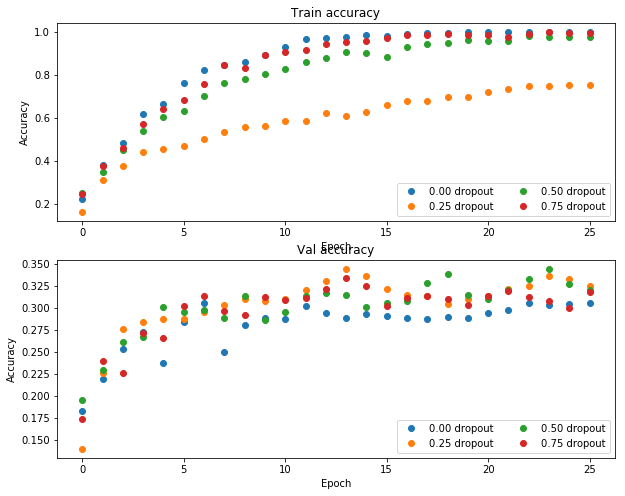

In [10]:
# Plot train and validation accuracies of the two models
train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(2, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
    
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(2, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
    
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')


plt.show()